In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pickle
%matplotlib inline

# Data Preparation 

#### Reading data and preparing the test, train and validation sets

In [2]:
# Hyper parameters 
input_size = 784
output_size = 10

In [3]:
class NN:
    def __init__(self, mode, datapath=None, hidden_dims=None, hparams={}, model_path=None):
        if mode=='train': assert (hidden_dims is not None) and bool(hparams)
        if mode=='test': assert model_path is not None
        self.mode = mode
        self.model_path = model_path
        self.lr = hparams.get('lr')
        self.weight_decay = hparams.get('weight_decay')
        self.num_epochs = hparams.get('num_epochs')
        self.Params = {}
        data = np.load(datapath)
        self.X_train = data['x_train'][:48000].reshape(48000, 784)
        self.y_train = data['y_train'][:48000]
        self.X_valid = data['x_train'][48000:].reshape(12000, 784)
        self.y_valid = data['y_train'][48000:]
        self.X_test = data['x_test'].reshape(10000, 784)
        self.y_test = data['y_test']
        if (mode == 'train'):
            self.hidden_dims=(512,512)
            self.init_method = hparams['init_method']
            self.initialize_weights(hidden_dims)
        elif(mode == 'test'):
            with open(model_path,'rb') as f:
                 self.Params = pickle.load(f)
    
    def initialize_weights(self, dims):
        n_hidden = len(dims)
        num_nodes = [input_size] + list(dims) + [output_size]
        print('Initialization Method: %s' % self.init_method)
        print('--------------\n')
        for i in range(n_hidden + 1):
            self.Params['b%d'%(i+1)] = np.zeros(num_nodes[i+1])
            if self.init_method == 'Normal':
                self.Params['W%d'%(i+1)] = np.random.normal(0, 1,
                                                            (num_nodes[i+1], num_nodes[i]))
            elif self.init_method == 'Glorot':
                D_Glorot = np.sqrt(6.0 / (num_nodes[i+1] + num_nodes[i]))
                self.Params['W%d'%(i+1)] = np.random.uniform(-D_Glorot, D_Glorot,
                                                            (num_nodes[i+1], num_nodes[i]))
            elif self.init_method == 'Zeros':
                np.zeros((num_nodes[i+1], num_nodes[i]))
            else:
                raise ValueError('Invalid initialization type: %s' % self.init_method)
    
    def forward(self, x):
        N = x.shape[0]
        n_hidden = int(len(self.Params.keys()) / 2)
        h_cache_list = []
        a_cache_list = []
        h = x
        for i in range(n_hidden):
            h, h_cache = self.fc_forward(h, self.Params['W%d'%(i+1)], self.Params['b%d'%(i+1)])
            h_cache_list.append(h_cache)
            if i != (n_hidden-1):
                h, a_cache = self.relu_forward(h)
                a_cache_list.append(a_cache)
        scores = h
        cache = (N, n_hidden, a_cache_list, h_cache_list)
        return scores, cache
    
    def backward(self, dloss, cache):
        (N, n_hidden, a_cache_list, h_cache_list) = cache
        dx = dloss
        grads = {}
        for i in range(n_hidden, 0, -1):
            dx, dW, db = self.fc_backward(dx, h_cache_list[i-1])
            grads['W%d'%i] = (dW / N) + (self.weight_decay * self.Params['W%d'%i])
            grads['b%d'%i] = (db / N)
            if i != 1:
                dx = self.relu_backward(dx, a_cache_list[i-2])
        return grads
        
    
    def fc_forward(self, x, w, b):        
        out = np.dot(x, w.T) + b
        cache = (x, w, b, out)
        return out, cache
    
    def fc_backward(self, dupstream, cache):        
        (x, w, b, out) = cache
        dx = np.dot(dupstream, w)
        dw = np.dot(dupstream.T, x)
        db = dupstream.sum(axis=0)
        return dx, dw, db
    
    ### Activation function
    def relu_forward(self, x):        
        return np.maximum(0, x), x
    
    def relu_backward(self, dupstream, cache):        
        return ((cache > 0) * dupstream)  
    
        
    def update(self, grads):
        for param, grad in grads.items():
                self.Params[param] -= self.lr * grad
    
    ### Calculate Softmax and loss function
    def softmax_loss(self, scores, y):
        shifted_logits = scores - np.max(scores, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)
        N = scores.shape[0]
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N
        return loss, dx
    
    def train(self, mb_size=100):
        train_loss_hist = []
        val_loss_hist = []
        train_accuracies = []
        val_accuracies = []
        for ep in range(self.num_epochs):
            for i in range(np.ceil(self.X_train.shape[0] / mb_size).astype('int')):
                xi = self.X_train[i*mb_size:(i+1)*mb_size]
                yi = self.y_train[i*mb_size:(i+1)*mb_size]
                scores, cache = self.forward(xi)
                train_loss, dloss = self.softmax_loss(scores, yi)
                grads = self.backward(dloss, cache)
                self.update(grads)
            
            scores_train, _ = self.forward(self.X_train)
            pred_train = np.argmax(scores_train, axis=1)
            train_loss, _ = self.softmax_loss(scores_train, self.y_train)
            
            scores_val,_ = self.forward(self.X_valid)
            pred_val = np.argmax(scores_val, axis=1)
            val_loss, _ = self.softmax_loss(scores_val, self.y_valid)
                
            train_loss_hist.append(train_loss)
            val_loss_hist.append(val_loss)
            train_acc = (pred_train == self.y_train).mean()
            val_acc = (pred_val == self.y_valid).mean()
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print('Epoch %d' % ep)
            print('Train: Loss: %.4f, Accuracy %.4f' % (train_loss, train_acc))
            print('Validation: Loss: %.4f, Accuracy %.4f\n' % (val_loss, val_acc))
            
        train_history = {'train_loss_hist':train_loss_hist,
                         'val_loss_hist':val_loss_hist,
                         'train_accuracies':train_accuracies,
                         'val_accuracies':val_accuracies}
        if self.model_path is not None:
            with open(self.model_path, 'wb') as f:
                pickle.dump(self.Params, f)
        return train_history
    
    def test(self, x):
        scores,_ = self.forward(x)
        return scores

### Helper Functions

In [4]:
def historyPlt(train_history):
    train_losses = ['train_loss_hist']
    train_accuracies = ['train_accuracies']
    valid_losses = train_history['val_loss_hist']
    valid_accuracies = train_history['val_accuracies']
    plt.figure(figsize=(12, 4))
    axis = plt.subplot(1, 2, 1)
#     axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
    axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
    axis.legend()
    axis.set_ylabel('Loss')
    axis.set_xlabel('Epochs')
    axis = plt.subplot(1, 2, 2)
#     axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
    axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
    axis.legend()
    axis.set_ylabel('Accuracy')
    axis.set_xlabel('Epochs')

def accuracy(scores, labels):
    preds = np.argmax(scores, axis=1)
    accuracy = (preds == labels).mean()
    return accuracy

### Optimal Hyperparameter Search

In [5]:
# # Initiate hyperparameters
# hparams = {'init_method': 'Glorot',
#           'num_epochs': 3}

# for i in range(100):
#     lr = 10 ** np.random.uniform(-2, 0)
#     weight_decay = 10 ** np.random.uniform(-5, 0)
    
#     hparams['lr'] = lr
#     hparams['weight_decay'] = weight_decay
#     print('lr: %.6f'%lr)
#     print('weight_decay: %.6f'%weight_decay)
#     # Initialize NN object
#     nn = NN((512,512), mode='train', hparams=hparams, datapath='./mnist.npz')
    
#     # Start training
#     train_history = nn.train()


# print('Training done!')

## Train Model

In [6]:
# lr: 0.054004
# weight_decay: 0.013356

# Initiate hyperparameters
hparams = {'init_method': 'Glorot',
           'lr': 1e-1,
          'weight_decay': 2e-3,
          'num_epochs': 10}

# Initialize NN object
nn = NN(mode='train', datapath='./mnist.npz', hidden_dims=(512, 512), hparams=hparams,
        model_path='Params.pkl')

# Start training
train_history = nn.train()
print('Training done!')

Initialization Method: Glorot
--------------

Epoch 0
Train: Loss: 0.3842, Accuracy 0.9359
Validation: Loss: 0.6048, Accuracy 0.9167

Epoch 1
Train: Loss: 0.1468, Accuracy 0.9623
Validation: Loss: 0.3630, Accuracy 0.9312

Epoch 2
Train: Loss: 0.0810, Accuracy 0.9753
Validation: Loss: 0.2593, Accuracy 0.9391

Epoch 3
Train: Loss: 0.0586, Accuracy 0.9843
Validation: Loss: 0.2036, Accuracy 0.9451

Epoch 4
Train: Loss: 0.0539, Accuracy 0.9886
Validation: Loss: 0.1715, Accuracy 0.9498

Epoch 5
Train: Loss: 0.0564, Accuracy 0.9901
Validation: Loss: 0.1520, Accuracy 0.9547

Epoch 6
Train: Loss: 0.0618, Accuracy 0.9895
Validation: Loss: 0.1398, Accuracy 0.9590

Epoch 7
Train: Loss: 0.0685, Accuracy 0.9881
Validation: Loss: 0.1328, Accuracy 0.9612

Epoch 8
Train: Loss: 0.0756, Accuracy 0.9858
Validation: Loss: 0.1293, Accuracy 0.9630

Epoch 9
Train: Loss: 0.0826, Accuracy 0.9839
Validation: Loss: 0.1278, Accuracy 0.9645

Training done!


### Plot Loss

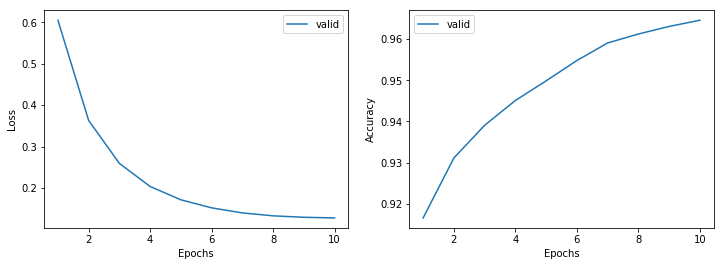

In [7]:
historyPlt(train_history)

In [9]:
nn = NN(mode='test', datapath='./mnist.npz', model_path='Params.pkl')
scores_train = nn.test(nn.X_train)
train_acc = accuracy(scores_train, nn.y_train)
print('Train accuracy: %.2f%%'% (train_acc * 100))

scores_val = nn.test(nn.X_valid)
val_acc = accuracy(scores_val, nn.y_valid)
print('Validation accuracy: %.2f%%'% (val_acc * 100))

scores_test = nn.test(nn.X_test)
test_acc = accuracy(scores_test, nn.y_test)
print('Test accuracy: %.2f%%'% (test_acc * 100))

Train accuracy: 98.39%
Validation accuracy: 96.45%
Test accuracy: 96.48%


# EXTRAS

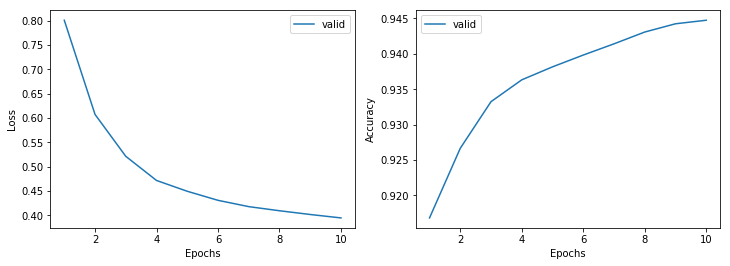

In [26]:
run_train(init_method = "Glorot", num_epochs=10)

In [27]:
run_test()

valid_accuracies:  0.9443


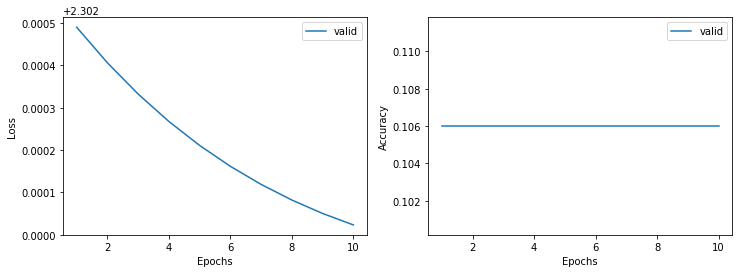

In [28]:
run_train(init_method = "zeros", num_epochs=10)

In [29]:
run_test()

valid_accuracies:  0.1135


## Second test:

In [30]:
learning_rate=1e-1
weight_decay=0.002

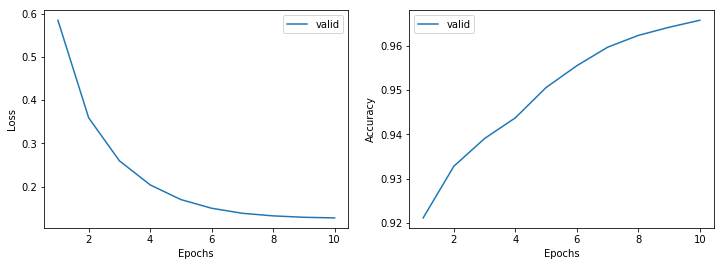

In [31]:
run_train(init_method = "Glorot", num_epochs=10)

In [32]:
run_test()

valid_accuracies:  0.9636


In [33]:
learning_rate=1e-2
weight_decay=0.0035

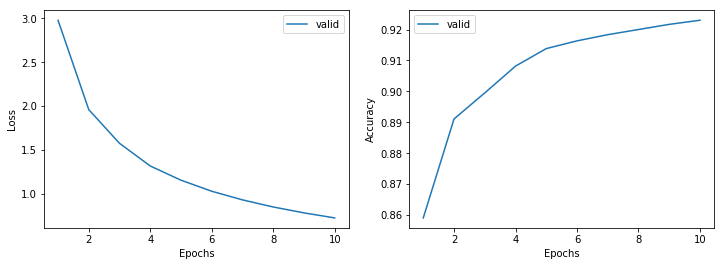

In [34]:
run_train(init_method = "Glorot", num_epochs=10)

In [35]:
run_test()

valid_accuracies:  0.9239


In [36]:
learning_rate=1e-1
weight_decay=0.0025

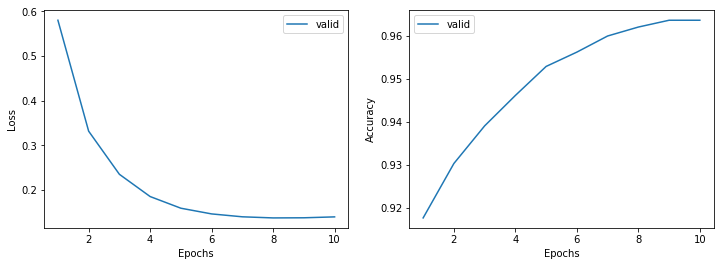

In [37]:
run_train(init_method = "Glorot", num_epochs=10)

In [38]:
run_test()

valid_accuracies:  0.9649


In [39]:
learning_rate=1e-1
weight_decay=0.0035

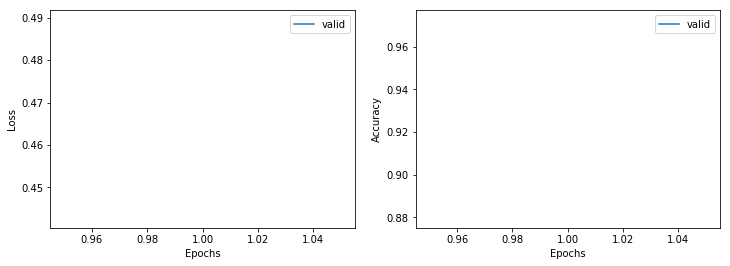

In [40]:
run_train(init_method = "Glorot", num_epochs=1)

In [41]:
run_test()

valid_accuracies:  0.9237
